In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
passengers_df = pd.read_csv('df_passengers.csv')

In [3]:
# Below steps are similar to what has been done during EDA to ensure dataset is correctly formatted for subsequent modelling.
passengers_df['Date'] = pd.to_datetime(passengers_df.Date, format="%d/%m/%Y", errors='coerce')
print(passengers_df.dtypes)

Date                        datetime64[ns]
total_passengers                     int64
total_passengers_arr                 int64
total_passengers_dep                 int64
total_passengers_transit             int64
dtype: object


In [4]:
passengers_df = passengers_df.set_index("Date")
passengers_df

,total_passengers,total_passengers_arr,total_passengers_dep,total_passengers_transit
Date,,,,
2025-02-01,5441857,2754111,2645524,42222
2025-01-01,6155064,3130805,2971086,53173
2024-12-01,6410825,3218469,3144724,47632
2024-11-01,5741007,2839182,2855880,45945
2024-10-01,5650043,2757008,2840028,53007
...,...,...,...,...
1980-05-01,587003,246876,257562,82565
1980-04-01,561218,240343,246241,74634
1980-03-01,597644,246262,254054,97328


In [5]:
# Filtering to data from Jan 1989 only
passengers_df = passengers_df.loc['1989-01-01':]
passengers_df.sort_values("Date", inplace=True)
passengers_df

,total_passengers,total_passengers_arr,total_passengers_dep,total_passengers_transit
Date,,,,
1989-01-01,1107283,503277,506179,97827
1989-02-01,1050398,479227,488700,82471
1989-03-01,1160644,531121,538332,91191
1989-04-01,1089718,493376,505403,90939
1989-05-01,1100198,499419,516145,84634
...,...,...,...,...
2024-10-01,5650043,2757008,2840028,53007
2024-11-01,5741007,2839182,2855880,45945
2024-12-01,6410825,3218469,3144724,47632


## Auto-ARIMA

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# To prevent COVID-19 figures from affecting the model, we will use data up till Dec 2019 for modelling.
p2019_df = passengers_df.loc['1989-01-01':'2019-12-01']
p2019_df

,total_passengers,total_passengers_arr,total_passengers_dep,total_passengers_transit
Date,,,,
1989-01-01,1107283,503277,506179,97827
1989-02-01,1050398,479227,488700,82471
1989-03-01,1160644,531121,538332,91191
1989-04-01,1089718,493376,505403,90939
1989-05-01,1100198,499419,516145,84634
...,...,...,...,...
2019-08-01,5900629,2926617,2911530,62482
2019-09-01,5469342,2726048,2682724,60570
2019-10-01,5646643,2787094,2801262,58287


In [8]:
import pmdarima as pm # to do Auto ARIMA
from pmdarima.arima import ADFTest # to perform ADF test 

In [9]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(p2019_df['total_passengers']) 

(0.9252193893119155, True)

#### Inference:
Null hypothesis: time series data is not stationary
Alternate hypothesis: time series data is stationary
- p=0.925, hence, we will not reject null hypothesis based on statistical proof. This is means our time series data is not stationary and differencing is needed

In [10]:
# Train-test split of time series data
y_train, y_test = train_test_split(p2019_df['total_passengers'], test_size=.1, shuffle=False)

In [11]:
arima_model = pm.AutoARIMA(start_p=12, max_p=36, 
                           d=None,    # find optimum value of d automatically
                           start_q=12, max_q=36, 
                           trace=True, # Print values in console for each fit in the grid search
                           random_state=20, # repeatability of steps in the same order
                           n_fits=50 # max no. of ARIMA models fits, the algorithm MUST stop at the end of 50 fits
                          )

arima_model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(12,1,12)(0,0,0)[0] intercept   : AIC=8842.833, Time=4.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9163.586, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9149.565, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9112.608, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9162.365, Time=0.04 sec
 ARIMA(11,1,12)(0,0,0)[0] intercept   : AIC=inf, Time=5.55 sec
 ARIMA(12,1,11)(0,0,0)[0] intercept   : AIC=8843.475, Time=4.61 sec
 ARIMA(13,1,12)(0,0,0)[0] intercept   : AIC=inf, Time=4.09 sec
 ARIMA(12,1,13)(0,0,0)[0] intercept   : AIC=inf, Time=5.88 sec
 ARIMA(11,1,11)(0,0,0)[0] intercept   : AIC=8846.608, Time=4.61 sec
 ARIMA(11,1,13)(0,0,0)[0] intercept   : AIC=inf, Time=5.73 sec
 ARIMA(13,1,11)(0,0,0)[0] intercept   : AIC=8852.999, Time=5.76 sec
 ARIMA(13,1,13)(0,0,0)[0] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(12,1,12)(0,0,0)[0]             : AIC=inf, Time=4.71 sec

Best model:  ARIMA(12,1,12)(0,0,0)[0] inte

AutoARIMA(max_p=36, max_q=36, n_fits=50, random_state=20, start_p=12,
          start_q=12, trace=True)

#### Inference:
Based on all the combinations checked, **ARIMA(12,1,12) p=12, d=1 and q=12** is the most optimal (i.e. lowest possible AIC score; estimator of out-of-sample prediction error).

In [12]:
# Making predictions using the ARIMA model we have identified until Feb 2025
len(y_test)

38

In [13]:
# From Jan 2020 to Feb 2025 => (12*5)+2 = 62 months of predictions
# Hence n_periods = 38 + 62 = 100
y_pred = arima_model.predict(n_periods = 100)
y_pred

2016-11-01    4.778472e+06
2016-12-01    5.365404e+06
2017-01-01    4.913501e+06
2017-02-01    4.632691e+06
2017-03-01    4.979990e+06
                  ...     
2024-10-01    6.003357e+06
2024-11-01    6.023852e+06
2024-12-01    6.415217e+06
2025-01-01    6.110708e+06
2025-02-01    5.849380e+06
Freq: MS, Length: 100, dtype: float64

In [14]:
# To look at how the predictions compare to actual data, we will limit the time period from 2016 till 2025
actual_2016to25 = passengers_df['total_passengers'].loc['2016-01-01':'2025-02-01']
actual_2016to25

Date
2016-01-01    4860156
2016-02-01    4602026
2016-03-01    4902767
2016-04-01    4793662
2016-05-01    4781918
               ...   
2024-10-01    5650043
2024-11-01    5741007
2024-12-01    6410825
2025-01-01    6155064
2025-02-01    5441857
Name: total_passengers, Length: 110, dtype: int64

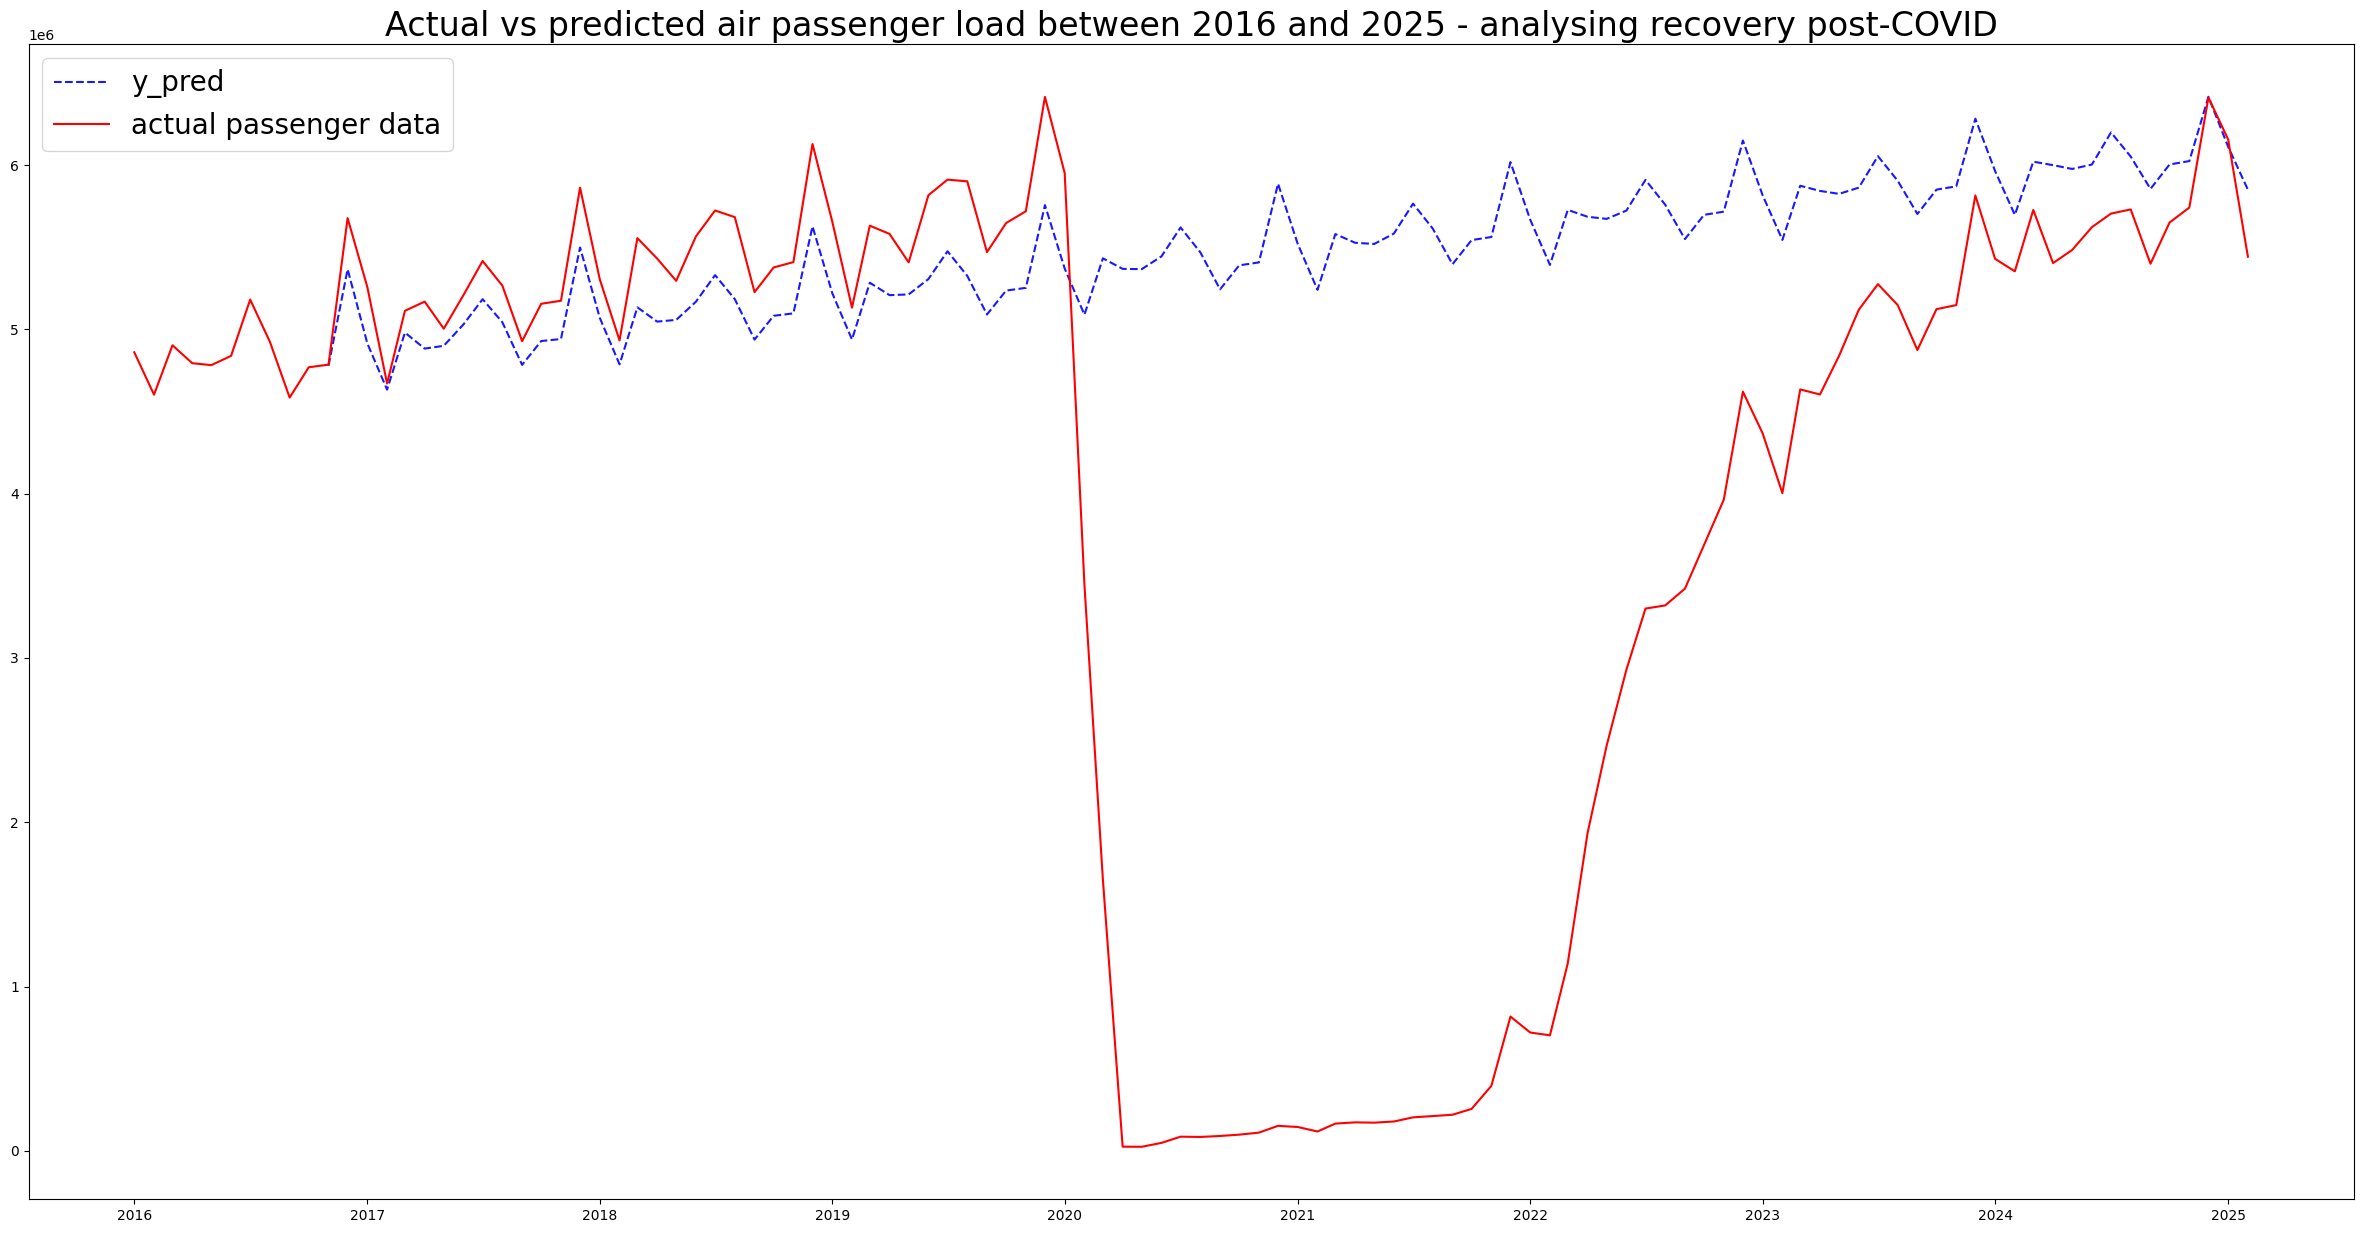

In [15]:
# To look at how the predictions compare to actual data, we will plot passengers_df['total_passengers'] as well as predicted values,
# zoomed into the time period from 2016 till 2025

plt.figure(figsize=(30,15))

plt.plot(y_pred, color='blue', label='y_pred', alpha = 0.9, ls = '--')
plt.plot(actual_2016to25, color='red', label='actual passenger data')

plt.title(label = 'Actual vs predicted air passenger load between 2016 and 2025 - analysing recovery post-COVID', fontsize=24)
plt.legend(fontsize = 20, loc = 'upper left');

#### Findings:
1. Sharp drop in air passenger load due COVID-19 around year 2020, with air travel remaining low until around 2022 when there is slight increment. However, the number of air passenger is much lower compared to what it would have been without the pandemic.
2. Air passengers handled by Changi Airport seemed to have recovered near the end of 2024 (around Dec 2024), where we saw the actual value going close to the predicted values based on the ARIMA model.
3. It took close to 3 years since borders were opened for air traffic to "recover". This is also evident if we compare the actual air passenger figures in 2025 with those pre-COVID (i.e. 2019).

In [25]:
# Save y_pred to CSV for plotting in PowerBI later.
y_pred.to_csv('y_pred.csv')